# 教程 5：分层路径积分网络

> **阅读时间**：约 35-40 分钟
> **难度**：高级
> **先决条件**：[教程 1-4](./01_build_cann_model.ipynb)

本教程介绍分层路径积分网络，它结合了多尺度网格细胞，用于大环境中的鲁棒空间导航。

---

## 目录

1. [分层路径积分介绍](#1-分层路径积分介绍)
2. [模型架构](#2-模型架构)
3. [完整示例：多尺度导航](#3-完整示例多尺度导航)
4. [可视化和分析](#4-可视化和分析)
5. [后续步骤](#5-后续步骤)

---

## 1. 分层路径积分简介

### 1.1 什么是分层路径积分?

路径积分是通过对自我运动信号(速度)进行时间积分来追踪位置的能力。**分层路径积分**使用多个在不同空间尺度上运行的网格细胞模块来实现:

- **多尺度表示**: 粗尺度用于大空间，细尺度用于精度
- **错误纠正**: 多个尺度提供针对漂移的冗余性
- **高效编码**: 不同的模块以不同的分辨率对空间进行平铺

### 1.2 生物学灵感

在哺乳动物脑中:
- **网格细胞**位于内侧内嗅皮层，以规则的空间间隔放电，形成六边形图案
- **多个模块**存在，具有不同的网格间距(30厘米到数米)
- **带状细胞**沿着优先方向积分速度
- **位置细胞**位于海马体，接收来自网格细胞的汇聚输入

### 1.3 关键组件

分层网络由以下部分组成:

1. **带状细胞** - 沿特定方向(0°、60°、120°)的速度积分器
2. **网格细胞** - 形成六边形图案的2D连续吸引子
3. **位置细胞** - 结合所有模块信息的读出层
4. **多模块架构** - 具有不同间距的多个网格模块

---

## 2. 模型架构

### 2.1 组件概述

In [1]:
from canns.models.basic import HierarchicalNetwork

# 创建具有5个模块的分层网络
hierarchical_net = HierarchicalNetwork(
    num_module=5,        # 网格模块的数量（不同尺度）
    num_place=30,        # 每个维度的位置细胞（30x30 = 900个总计）
    spacing_min=2.0,     # 最小网格间距
    spacing_max=5.0,     # 最大网格间距
    module_angle=0.0     # 基础方向角
)

### 2.2 关键参数

| 参数 | 类型 | 描述 |
|-----------|------|-------------|
| `num_module` | int | 具有不同尺度的网格模块数量 |
| `num_place` | int | 每个空间维度的位置细胞数 |
| `spacing_min` | float | 最小网格间距（最精细尺度） |
| `spacing_max` | float | 最大网格间距（最粗糙尺度） |
| `module_angle` | float | 网格模块的基础方向 |

**参数指南**：
- `num_module=5`：在覆盖范围和计算量之间取得良好平衡
- `num_place=30`：为5x5m环境提供900个位置细胞
- 间距范围应与环境大小相匹配（更大的空间需要更大的`spacing_max`）

### 2.3 内部结构

每个模块包含：
- **3个BandCell网络**，方向分别为0°、60°、120°
- **1个GridCell网络**，结合带状细胞输出
- 连接投影到共享的位置细胞群体

---

## 3. 完整示例：多尺度导航

### 3.1 设置和任务创建

In [1]:
import brainpy.math as bm
import brainunit as u
import numpy as np
from canns.models.basic import HierarchicalNetwork
from canns.task.open_loop_navigation import OpenLoopNavigationTask

# 设置环境
bm.set_dt(0.05)

# 创建导航任务（5m x 5m环境）
task = OpenLoopNavigationTask(
    width=5.0,           # 环境宽度（米）
    height=5.0,          # 环境高度（米）
    speed_mean=0.04,     # 平均速度（米/步）
    speed_std=0.016,     # 速度标准差
    duration=50000.0,    # 仿真时长（步）
    dt=0.05,             # 时间步长
    start_pos=(2.5, 2.5), # 从中心开始
    progress_bar=True
)

# 生成轨迹数据
task.get_data()

print(f"轨迹：{task.data.position.shape[0]} 步")
print(f"环境：{task.width}m x {task.height}m")

<OpenLoopNavigationTask>Generating Task data: 100%|██████████| 1000000/1000000 [00:00<00:00, 1565072.09it/s]


Trajectory: 1000000 steps
Environment: 5.0m x 5.0m


### 3.2 创建分层网络

In [ ]:
# 创建分层网络
hierarchical_net = HierarchicalNetwork(
    num_module=5,         # 5个不同的空间尺度
    num_place=30,         # 30x30位置细胞网格
    spacing_min=2.0,      # 最精细的网格尺度
    spacing_max=5.0,      # 最粗糙的网格尺度
)

### 3.3 初始化阶段

**关键步骤**：使用强位置输入初始化网络以设置初始位置。

In [ ]:
def initialize(t, input_strength):
    """使用位置输入初始化网络"""
    hierarchical_net(
        velocity=u.math.zeros(2,),        # 初始化期间无速度
        loc=task.data.position[0],        # 起始位置
        loc_input_stre=input_strength,    # 输入强度
    )

# 创建初始化计划
init_time = 500
indices = np.arange(init_time)
input_strength = np.zeros(init_time)
input_strength[:400] = 100.0  # 前400步的强输入

# 运行初始化
bm.for_loop(
    initialize,
    operands=(
        u.math.asarray(indices),
        u.math.asarray(input_strength),
    ),
    progress_bar=10,
)

print("初始化完成")

**为什么初始化很重要**：
- 将所有网格模块设置为一致的起始状态
- 强大的位置输入（100.0）锚定网络
- 没有适当的初始化，模块可能会开始不同步

### 3.4 主模拟循环

In [ ]:
def run_step(t, vel, loc):
    """单个模拟步骤，带速度输入"""
    hierarchical_net(
        velocity=vel,           # 当前速度
        loc=loc,                # 当前位置（仅供参考）
        loc_input_stre=0.0      # 导航期间无位置输入
    )

    # 从所有层提取放电率
    band_x_r = hierarchical_net.band_x_fr.value   # X方向带状细胞
    band_y_r = hierarchical_net.band_y_fr.value   # Y方向带状细胞
    grid_r = hierarchical_net.grid_fr.value       # 网格细胞
    place_r = hierarchical_net.place_fr.value     # 位置细胞

    return band_x_r, band_y_r, grid_r, place_r

# 获取轨迹数据
total_time = task.data.velocity.shape[0]
indices = np.arange(total_time)

# 运行模拟
print("运行主模拟...")
band_x_r, band_y_r, grid_r, place_r = bm.for_loop(
    run_step,
    operands=(
        u.math.asarray(indices),
        u.math.asarray(task.data.velocity),
        u.math.asarray(task.data.position),
    ),
    progress_bar=10000,
)

print(f"模拟完成！")
print(f"带状X细胞：{band_x_r.shape}")
print(f"带状Y细胞：{band_y_r.shape}")
print(f"网格细胞：{grid_r.shape}")
print(f"位置细胞：{place_r.shape}")

**理解输出**：
- `band_x_r`：形状 (T, num_module, num_cells) - X分量的条带细胞
- `band_y_r`：形状 (T, num_module, num_cells) - Y分量的条带细胞
- `grid_r`：形状 (T, num_module, num_gc_x, num_gc_y) - 网格细胞活动
- `place_r`：形状 (T, num_place, num_place) - 位置细胞反应

---

## 4. 可视化与分析

### 4.1 计算放电场

放电场显示每个神经元在环境中活跃的位置：

In [ ]:
from canns.analyzer.spatial import compute_firing_field, gaussian_smooth_heatmaps
from canns.analyzer.plotting import PlotConfig, plot_firing_field_heatmap

# 准备数据
loc = np.array(task.data.position)
width, height = 5.0, 5.0
M, K = 50, 50  # 空间网格 (50x50 网格)

T = grid_r.shape[0]

# 重塑数组用于放电场计算
grid_r = np.array(grid_r).reshape(T, -1)
band_x_r = np.array(band_x_r).reshape(T, -1)
band_y_r = np.array(band_y_r).reshape(T, -1)
place_r = np.array(place_r).reshape(T, -1)

# 计算放电场
print("正在计算放电场...")
heatmaps_grid = compute_firing_field(grid_r, loc, width, height, M, K)
heatmaps_band_x = compute_firing_field(band_x_r, loc, width, height, M, K)
heatmaps_band_y = compute_firing_field(band_y_r, loc, width, height, M, K)
heatmaps_place = compute_firing_field(place_r, loc, width, height, M, K)

# 应用高斯平滑
heatmaps_grid = gaussian_smooth_heatmaps(heatmaps_grid)
heatmaps_band_x = gaussian_smooth_heatmaps(heatmaps_band_x)
heatmaps_band_y = gaussian_smooth_heatmaps(heatmaps_band_y)
heatmaps_place = gaussian_smooth_heatmaps(heatmaps_place)

print(f"放电场计算完成: {heatmaps_grid.shape}")

Computing firing fields...
Firing fields computed: (2000, 50, 50)


### 4.2 可视化网格细胞模式

网格细胞表现出特征性的六边形放电模式：

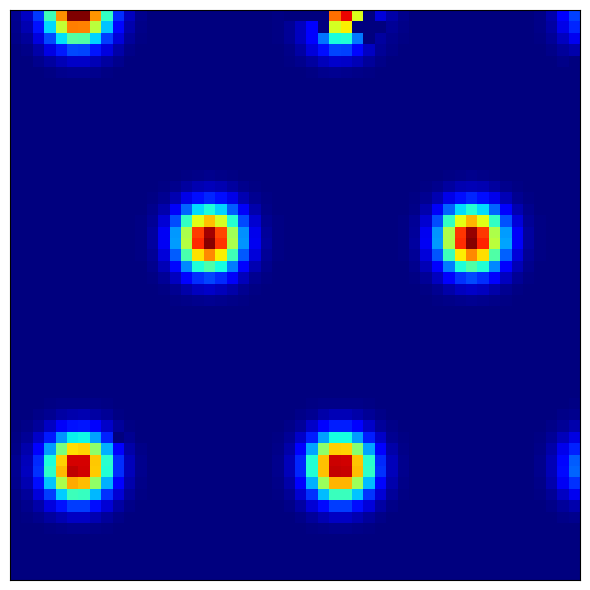

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [ ]:
# 重新整形以分离模块heatmaps_grid = heatmaps_grid.reshape(5, -1, M, K)  # (modules, cells, x, y)# 可视化来自模块0的网格单元module_idx = 0cell_idx = 10config = PlotConfig(    figsize=(6, 6),    title=f'网格单元 - 模块 {module_idx}, 单元 {cell_idx}',    xlabel='X Position (m)',    ylabel='Y Position (m)',    show=True,    save_path=None)plot_firing_field_heatmap(    heatmaps_grid[module_idx, cell_idx],    config=config)

**观察重点**：
- **模块 0**（最精细尺度）：小型、紧密排列的六边形
- **模块 4**（最粗糙尺度）：大型、间距宽的六边形
- **规则间距**：网格顶点形成等边三角形

### 4.3 可视化带状细胞模式

带状细胞沿其优选方向呈现条纹状图案：

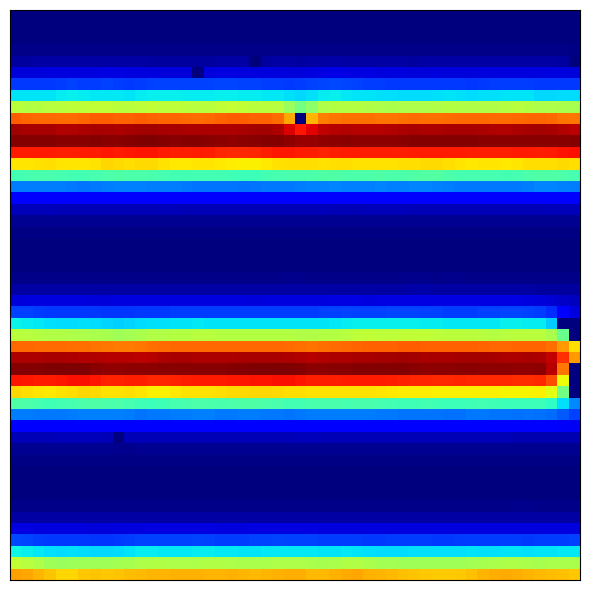

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [8]:
# 重新整形带状细胞heatmaps_band_x = heatmaps_band_x.reshape(5, -1, M, K)# 可视化带状细胞config = PlotConfig(    figsize=(6, 6),    title=f'带状细胞 X - 模块 {module_idx}, 细胞 {cell_idx}',    xlabel='X Position (m)',    ylabel='Y Position (m)',    show=True,    save_path=None)plot_firing_field_heatmap(    heatmaps_band_x[module_idx, cell_idx],    config=config)

**预期模式**：
- **平行条纹**垂直于优选方向
- 不同的细胞具有不同的条纹间距（相位偏移）
- 多个模块显示不同规模的条纹

### 4.4 可视化位置细胞场

位置细胞结合网格细胞输入以形成局部放电场：

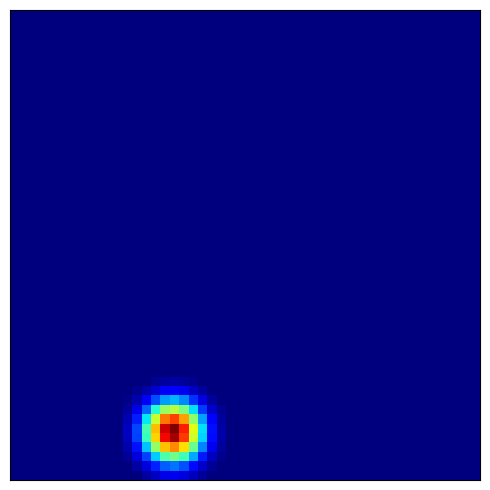

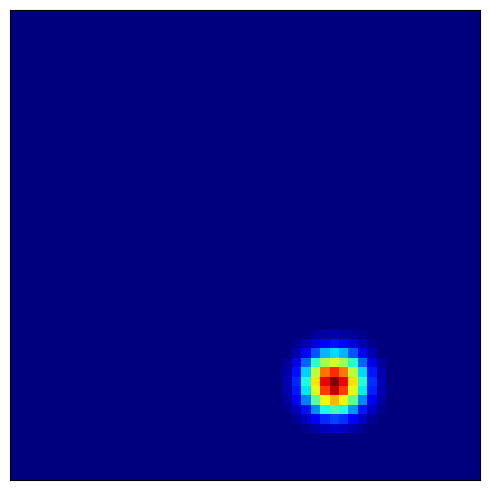

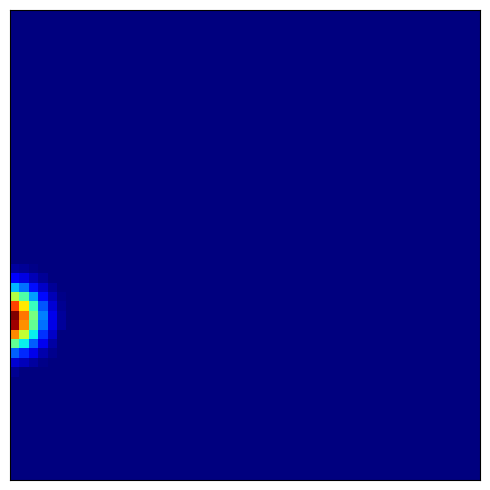

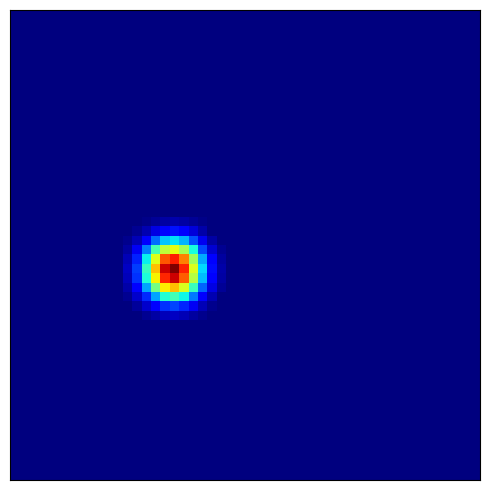

In [9]:
# 可视化多个位置细胞for place_idx in [100, 200, 300, 400]:    config = PlotConfig(        figsize=(5, 5),        title=f'位置细胞 {place_idx}',        xlabel='X Position (m)',        ylabel='Y Position (m)',        show=True,        save_path=None    )    plot_firing_field_heatmap(        heatmaps_place[place_idx],        config=config    )

**预期模式**:
- **局部化场域**: 每个位置细胞在特定位置激发
- **多个场域**: 某些细胞可能在多个激发位置
- **覆盖**: 不同细胞平铺整个环境

---

## 5. 后续步骤

恭喜！您已学会如何使用分层路径积分网络进行多尺度空间导航。

### 关键要点

1. **多尺度表示** - 不同模块处理不同的空间尺度
2. **初始化至关重要** - 强位置输入设置一致的起始状态
3. **带状细胞积分速度** - 沿优选方向形成1D条纹
4. **网格细胞形成六边形** - 从带状细胞相互作用中涌现
5. **位置细胞组合多尺度** - 提供独特的位置编码

### 何时使用分层网络

- **大型环境**：当单尺度网格不足时
- **稳健导航**：多个尺度提供纠错功能
- **生物真实性**：与内嗅皮层的神经记录相匹配
- **研究应用**：研究网格细胞形成和路径积分

### 继续学习

- **下一步**：[教程 6：Theta 扫描系统模型](./06_theta_sweep_hd_grid.ipynb) - 了解导航中的 theta 振荡
- **替代方案**：[教程 7：Theta 扫描位置细胞网络](./07_theta_sweep_place_cell.ipynb) - 带有障碍物的复杂环境

### 高级主题

- **模块相互作用**：不同尺度如何相互影响
- **误差累积**：比较单尺度与多尺度性能
- **参数调优**：优化不同环境的间距范围
- **生物学验证**：与实验数据的比较

### 相关模型

这些分层模型在 CANNs 库中可用：
- `BandCell` - 单个速度积分器
- `GridCell` - 2D 六边形吸引子
- `HierarchicalPathIntegrationModel` - 单个模块（3 个带状 + 1 个网格）
- `HierarchicalNetwork` - 多模块系统（本教程中使用）

有关更多详细信息，请参阅 [API 文档](../../api_reference.ipynb) 或浏览 `canns.models.basic.hierarchical_model` 中的源代码。